# One Hidden Layer Tanh Model

In [2]:
class OneLayerTanhModel(object):
    
    def __init__(
        self, 
        true_param_dict, 
        num_training_samples=10, 
        input_dim=1, 
        output_dim=1,
        num_hidden_nodes=1, 
        itemp=1.0,
        sigma=1.0
    ):
        self.true_param_dict = true_param_dict
        self.num_hidden_nodes = num_hidden_nodes
        self.num_training_samples = num_training_samples
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.itemp=1.0
        
        self.X, self.Y = self.generate_data(num_training_samples)        
        self.rng_key, self.rng_key_predict = random.split(random.PRNGKey(0))
#         self.observation_noise_spread_dist = dist.Gamma(3.0, 1.0)
        
        
    def regression_func(self, X, param_dict):
        W1 = param_dict["W1"]
        W2 = param_dict["W2"]
        return jnp.matmul(jnp.tanh(jnp.matmul(X, W1)), W2)
    
    def expected_nll(self, param_dict):
        y_hat = self.regression_func(self.X, param_dict)
        nll = 1 / (2 * self.sigma**2) * jnp.sum((self.Y - y_hat)**2, axis=0)
        return nll
    
    def model(self, X, Y, itemp=None):
        param_dict = dict(
            W1 = numpyro.sample(
                "W1", 
                dist.Normal(
                    jnp.zeros((self.input_dim, self.num_hidden_nodes)), 
                    jnp.ones((self.input_dim, self.num_hidden_nodes))
                )
            ),
            W2 = numpyro.sample(
                "W2", 
                dist.Normal(
                    jnp.zeros((self.num_hidden_nodes, self.output_dim)), 
                    jnp.ones((self.num_hidden_nodes, self.output_dim))
                )
            )
        )
        y_hat = self.regression_func(X, param_dict)
        if itemp is None:
            itemp = self.itemp
        with numpyro.plate("data", X.shape[0]), numpyro.handlers.scale(scale=itemp):
            numpyro.sample("Y", dist.Normal(y_hat, self.sigma), obs=Y)
        return
    
    def generate_data(self, num_training_samples):
        X = 2 * np.random.rand(num_training_samples, self.input_dim) - 1
        Y = self.regression_func(X, self.true_param_dict)
        Y += self.sigma * np.random.randn(*Y.shape)
        return X, Y

    def run_inference(
        self, 
        num_warmup, 
        num_posterior_samples, 
        num_chains, 
        print_summary=False, 
        progress_bar=False, 
        extra_fields=('potential_energy',), 
        itemp=None
    ):
        start = time.time()
        kernel = NUTS(
            self.model, 
        )
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_posterior_samples,
            num_chains=num_chains,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else progress_bar,
        )
        self.mcmc.run(
            self.rng_key, 
            self.X, 
            self.Y, 
            itemp=itemp,
            extra_fields=extra_fields
        )
        if print_summary:
            mcmc.print_summary()
            print("\nMCMC elapsed time:", time.time() - start)
        return self.mcmc.get_samples()
    
    def predict(self, posterior_samples, X):
        def _helper(rng_key, posterior_samples, X):
            model = handlers.substitute(handlers.seed(self.model, rng_key), posterior_samples)
            # note that Y will be sampled in the model because we pass Y=None here
            model_trace = handlers.trace(model).get_trace(X=X, Y=None)
            return model_trace["Y"]["value"]
        num_posterior_samples = self.mcmc.num_samples * self.mcmc.num_chains
        vmap_args = (
            posterior_samples,
            random.split(self.rng_key_predict, num_posterior_samples),
        )
        predictions = vmap(
            lambda samples, rng_key: _helper(rng_key, samples, X)
        )(*vmap_args)
        return predictions
    
    
    def true_rlct(self):
        h = int(self.num_hidden_nodes ** 0.5)
        H = self.num_hidden_nodes
        return (H + h * h + h) / (4 * h + 2)
        

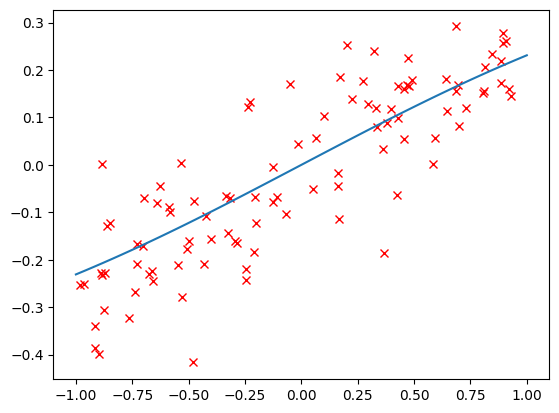

In [116]:
true_param_dict = {
    "W1": jnp.array([[0.5]]),
    "W2": jnp.array([[0.5]])
}
input_dim, num_hidden_nodes = true_param_dict["W1"].shape
output_dim = true_param_dict["W2"].shape[1]
num_training_samples = 100
one_layer_tanh = OneLayerTanhModel(
    true_param_dict, 
    num_training_samples=num_training_samples,
    input_dim=input_dim, 
    output_dim=output_dim,
    num_hidden_nodes=num_hidden_nodes,
    sigma=0.1, 
    itemp=1.0
)

plt.plot(one_layer_tanh.X, one_layer_tanh.Y, "rx");
a = np.linspace(-1, 1, num=50)[:, np.newaxis]
plt.plot(a, one_layer_tanh.regression_func(a, true_param_dict));

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:86: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1300/1300 [00:01<00:00, 1187.83it/s, 3 steps of size 6.98e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at sit

Expected log joint density: 9064.03
Expected nll 47.70
190.016


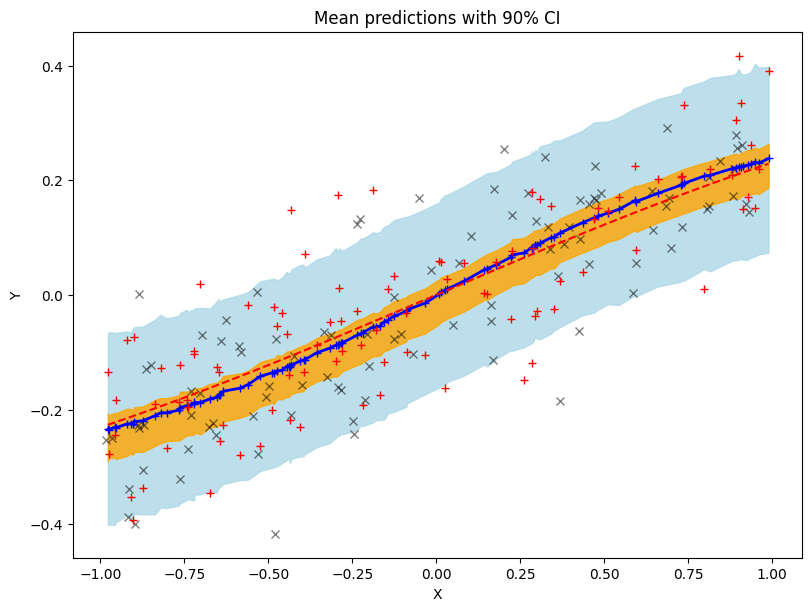

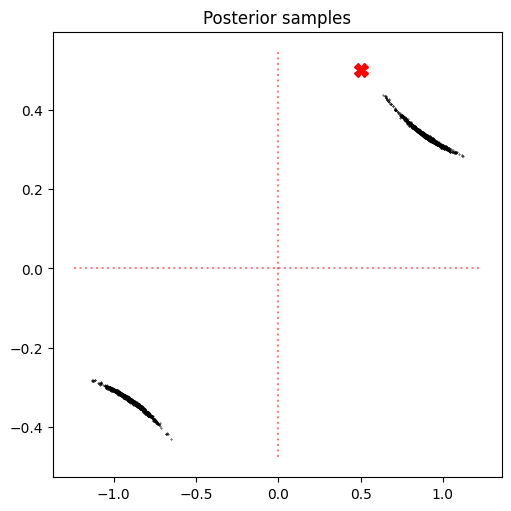

In [117]:
posterior_samples = one_layer_tanh.run_inference(
    num_warmup=300, 
    num_posterior_samples=1000, 
    num_chains=4,
    progress_bar=True, 
    itemp=1.0
)

X_test, Y_test = one_layer_tanh.generate_data(100)

sort_index = np.argsort(X_test[:, 0])
X_test = X_test[sort_index]
Y_test = Y_test[sort_index]

preds = one_layer_tanh.predict(posterior_samples, X_test)[..., 0] # shape = (posterior, test, )
mean_prediction = jnp.mean(preds, axis=0)
percentiles = np.percentile(preds, [5.0, 95.0], axis=0)
percentiles2 = np.percentile(preds, [30.0, 60.0], axis=0)


# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(one_layer_tanh.X, one_layer_tanh.Y, "kx", alpha=0.5)
# plot 90% confidence level of predictions
ax.fill_between(X_test[:, 0], percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.8)
ax.fill_between(X_test[:, 0], percentiles2[0, :], percentiles2[1, :], color="orange", alpha=0.8)

# plot mean prediction
ax.plot(X_test[:, 0], mean_prediction, color="blue", ls="solid", lw=2.0, marker="+")
ax.plot(X_test[:, 0], Y_test[:, 0], "r+")
ax.plot(X_test[:, 0], one_layer_tanh.regression_func(X_test, true_param_dict), "r--")
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");


# a = np.linspace(-1, 1, num=50)[:, np.newaxis]
# ax.plot(a, one_layer_tanh.regression_func(a, true_param_dict), color="r")
# preds[0][0]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

i1, i2 = 0, 0
j1, j2 = 0, 0
ax.plot(posterior_samples["W1"][:, i1, i2], posterior_samples["W2"][:, j1, j2], "kx", markersize=1, alpha=0.5)
ax.plot([true_param_dict["W1"][i1, i2]], [true_param_dict["W2"][j1, j2]], "rX", markersize=10)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
ax.set_title("Posterior samples");

pe = one_layer_tanh.mcmc.get_extra_fields()["potential_energy"]
nmpe = np.mean(-pe)
print(f'Expected log joint density: {nmpe:.2f}')

nlls = []
for i in range(one_layer_tanh.mcmc.num_samples * one_layer_tanh.mcmc.num_chains):
    param_dict = {name: param[i] for name, param in posterior_samples.items()}
    nlls.append(one_layer_tanh.expected_nll(param_dict))

enll = np.mean(nlls)
print(f"Expected nll {enll:.2f}")
print(nmpe / enll)

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:86: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 977.91it/s, 3 steps of size 4.42e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at sit

Finished itemp=0.1455961144604273. Expected NLL=47.77244567871094


sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 1014.52it/s, 3 steps of size 5.87e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2105.68it/s, 87 steps of size 2.17e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3312.80it/s, 35 steps of size 6.69e-02. acc. prob=0.91]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.16149636479180476. Expected NLL=47.764408111572266


sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 1065.04it/s, 3 steps of size 7.16e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2882.49it/s, 27 steps of size 4.19e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2473.86it/s, 55 steps of size 5.72e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.17739661512318222. Expected NLL=47.75872802734375


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 947.15it/s, 9 steps of size 2.82e-02. acc. prob=0.97]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3403.23it/s, 27 steps of size 5.20e-02. acc. prob=0.91]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3654.77it/s, 31 steps of size 7.95e-02. acc. prob=0.88]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.1932968654545597. Expected NLL=47.74921798706055


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 944.94it/s, 7 steps of size 4.76e-02. acc. prob=0.97]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3068.00it/s, 55 steps of size 5.18e-02. acc. prob=0.93]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:00<00:00, 3537.94it/s, 7 steps of size 5.27e-02. acc. prob=0.87]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.20919711578593714. Expected NLL=47.7454833984375


sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1024.86it/s, 17 steps of size 5.28e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2571.46it/s, 83 steps of size 1.91e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3380.74it/s, 43 steps of size 6.40e-02. acc. prob=0.93]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.22509736611731462. Expected NLL=47.74317169189453


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 904.58it/s, 3 steps of size 1.67e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3346.84it/s, 39 steps of size 5.35e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2863.26it/s, 51 steps of size 7.13e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.24099761644869208. Expected NLL=47.736061096191406


sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 983.37it/s, 13 steps of size 4.90e-02. acc. prob=0.97]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2798.83it/s, 31 steps of size 3.54e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2583.20it/s, 39 steps of size 5.21e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.25689786678006954. Expected NLL=47.7357177734375


sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 1063.28it/s, 3 steps of size 9.38e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2709.15it/s, 55 steps of size 3.90e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3743.62it/s, 39 steps of size 5.27e-02. acc. prob=0.90]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.27279811711144697. Expected NLL=47.73063278198242


sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1076.75it/s, 17 steps of size 5.90e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3365.11it/s, 43 steps of size 4.49e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3882.55it/s, 23 steps of size 7.17e-02. acc. prob=0.88]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=0.28869836744282446. Expected NLL=47.727508544921875


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 983.67it/s, 3 steps of size 1.39e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3426.32it/s, 51 steps of size 3.26e-02. acc. prob=0.93]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3552.70it/s, 27 steps of size 8.18e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=1.0. Expected NLL=47.700740814208984


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 996.04it/s, 3 steps of size 1.48e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3149.97it/s, 51 steps of size 2.96e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3147.26it/s, 39 steps of size 5.82e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=2.0. Expected NLL=47.695655822753906


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 953.56it/s, 3 steps of size 6.80e-03. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 3345.76it/s, 51 steps of size 4.71e-03. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2878.64it/s, 39 steps of size 4.11e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=5.0. Expected NLL=47.69320297241211


sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 1107.01it/s, 37 steps of size 7.84e-03. acc. prob=0.71]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:00<00:00, 2545.21it/s, 79 steps of size 2.93e-03. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_97627/1689413576.py:93: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:00<00:00, 2427.90it/s, 7 steps of size 3.63e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/i

Finished itemp=15.0. Expected NLL=47.69123077392578


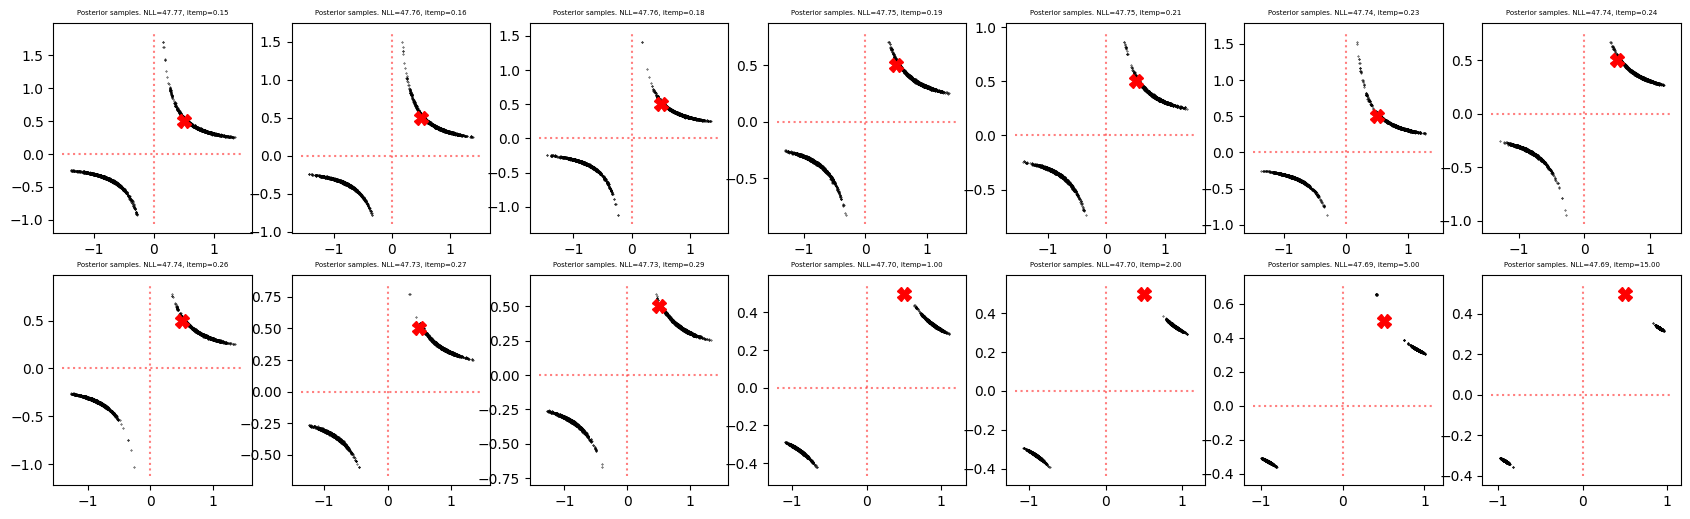

In [118]:
num_itemps = 10
n = one_layer_tanh.num_training_samples
itemps = np.linspace(
    1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
    1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), 
    num_itemps
)

itemps = np.array(list(itemps) + [1.0, 2.0, 5.0, 15.0])

num_rows = 2
num_cols = len(itemps) // num_rows + (len(itemps) % num_rows != 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
axes = np.ravel(axes)
enlls = []
for i, itemp in enumerate(itemps):
    ax = axes[i]
    posterior_samples = one_layer_tanh.run_inference(
        num_warmup=100, 
        num_posterior_samples=1000,
        num_chains=4,
        progress_bar=True, 
        itemp=itemp
    )
    nlls = []
    for i in range(one_layer_tanh.mcmc.num_samples * one_layer_tanh.mcmc.num_chains):
        param_dict = {name: param[i] for name, param in posterior_samples.items()}
        nlls.append(one_layer_tanh.expected_nll(param_dict))

    enll = np.mean(nlls)
    enlls.append(enll)
    print(f"Finished itemp={itemp}. Expected NLL={enll}")
    
    i1, i2 = 0, 0
    j1, j2 = 0, 0
    ax.plot(posterior_samples["W1"][:, i1, i2], posterior_samples["W2"][:, j1, j2], "kx", markersize=1, alpha=0.5)
    ax.plot([true_param_dict["W1"][i1, i2]], [true_param_dict["W2"][j1, j2]], "rX", markersize=10)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
    ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
    ax.set_title(f"Posterior samples. NLL={enll:.2f}, itemp={itemp:.2f}", fontdict={"fontsize": 5});


R^2=0.9959293939709155
R^2=0.9921721342131432
R^2=0.9953198107795984


Text(0, 0.5, 'Expected NLL')

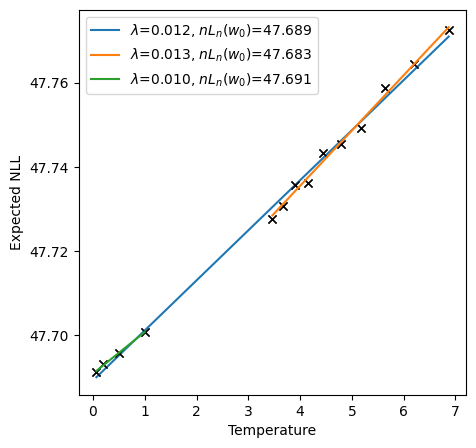

In [121]:
import scipy

fig, ax = plt.subplots(figsize=(5,5))


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
ax.plot(1/itemps, enlls, "kx")
ax.plot(1/itemps, 1/itemps * slope + intercept, label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}")
print(f"R^2={r_val**2}")


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[:num_itemps], enlls[:num_itemps])
ax.plot(1/itemps[:num_itemps], enlls[:num_itemps], "kx")
ax.plot(
    1/itemps[:num_itemps], 
    1/itemps[:num_itemps] * slope + intercept, 
    label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
)
print(f"R^2={r_val**2}")


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[num_itemps:], enlls[num_itemps:])
ax.plot(1/itemps[num_itemps:], enlls[num_itemps:], "kx")
ax.plot(
    1/itemps[num_itemps:], 
    1/itemps[num_itemps:] * slope + intercept, 
    label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
)
print(f"R^2={r_val**2}")

ax.legend()
ax.set_xlabel("Temperature")
ax.set_ylabel("Expected NLL")

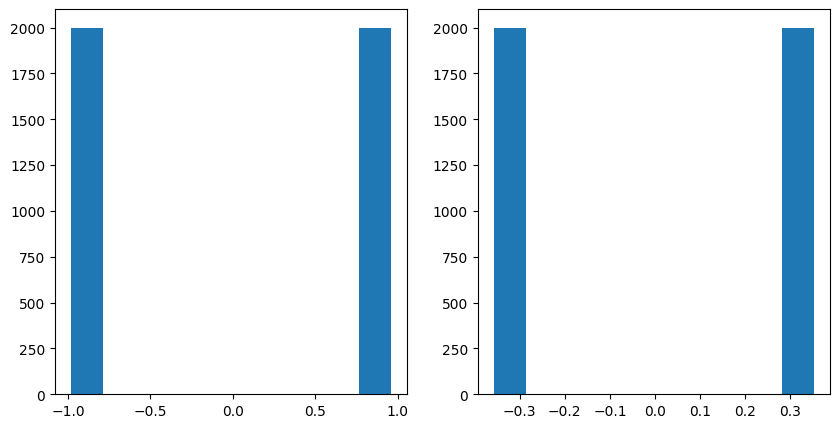

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.hist(posterior_samples["W1"][:, :, 0].flatten())
ax = axes[1]
ax.hist(posterior_samples["W2"][:, :, 0].flatten());